In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import sklearn as sk

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Load every available dataset.

In [2]:
%%time
adatas = []
for i, row in pd.read_csv('personal.csv').iterrows():
    try:
        adata = sc.read(f'datasets/{row.Author}_{row.Year}.h5ad')
        adata.obs['dataset'] = f'{row.Author}_{row.Year}'
        adatas.append(adata)
    except FileNotFoundError:
        pass
    
adata = ad.concat(adatas)

CPU times: user 1min 59s, sys: 48.9 s, total: 2min 48s
Wall time: 2min 49s


## Explore the data

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sc.set_figure_params(dpi=100, frameon=False)

,nth condition,condition,n_samples
0,0,ELF1,11676
1,1,control,8878
2,2,CREB1,7587
3,3,ELK1,7366
4,4,INTERGENIC393453,7177


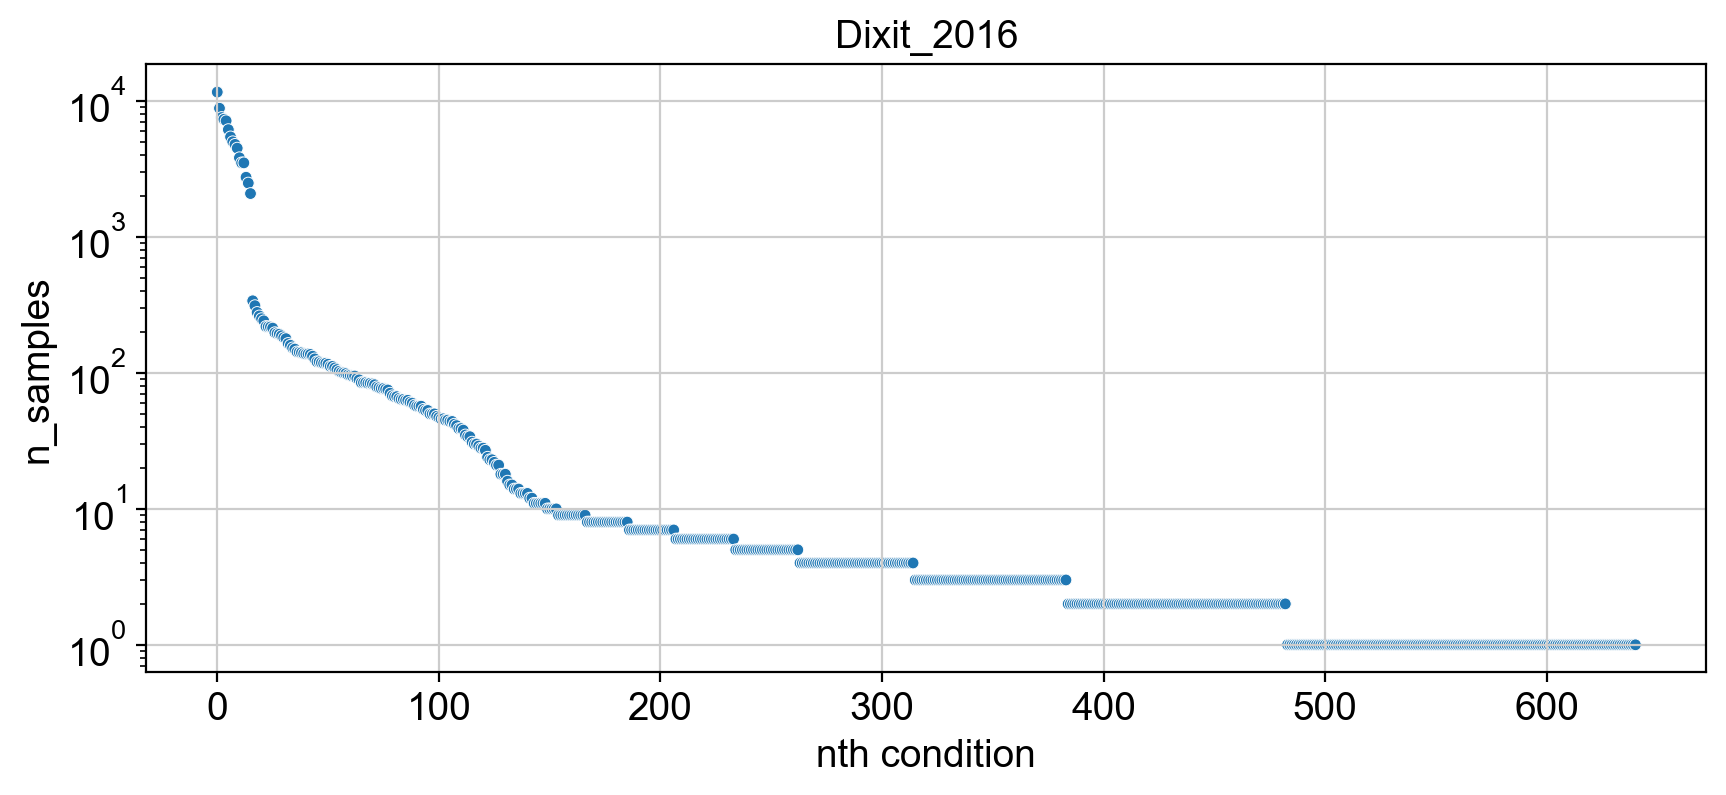

,nth condition,condition,n_samples
0,0,,11835
1,1,KLF1,1954
2,2,BAK1,1451
3,3,CEBPE,1230
4,4,"CEBPE,RUNX1T1",1215


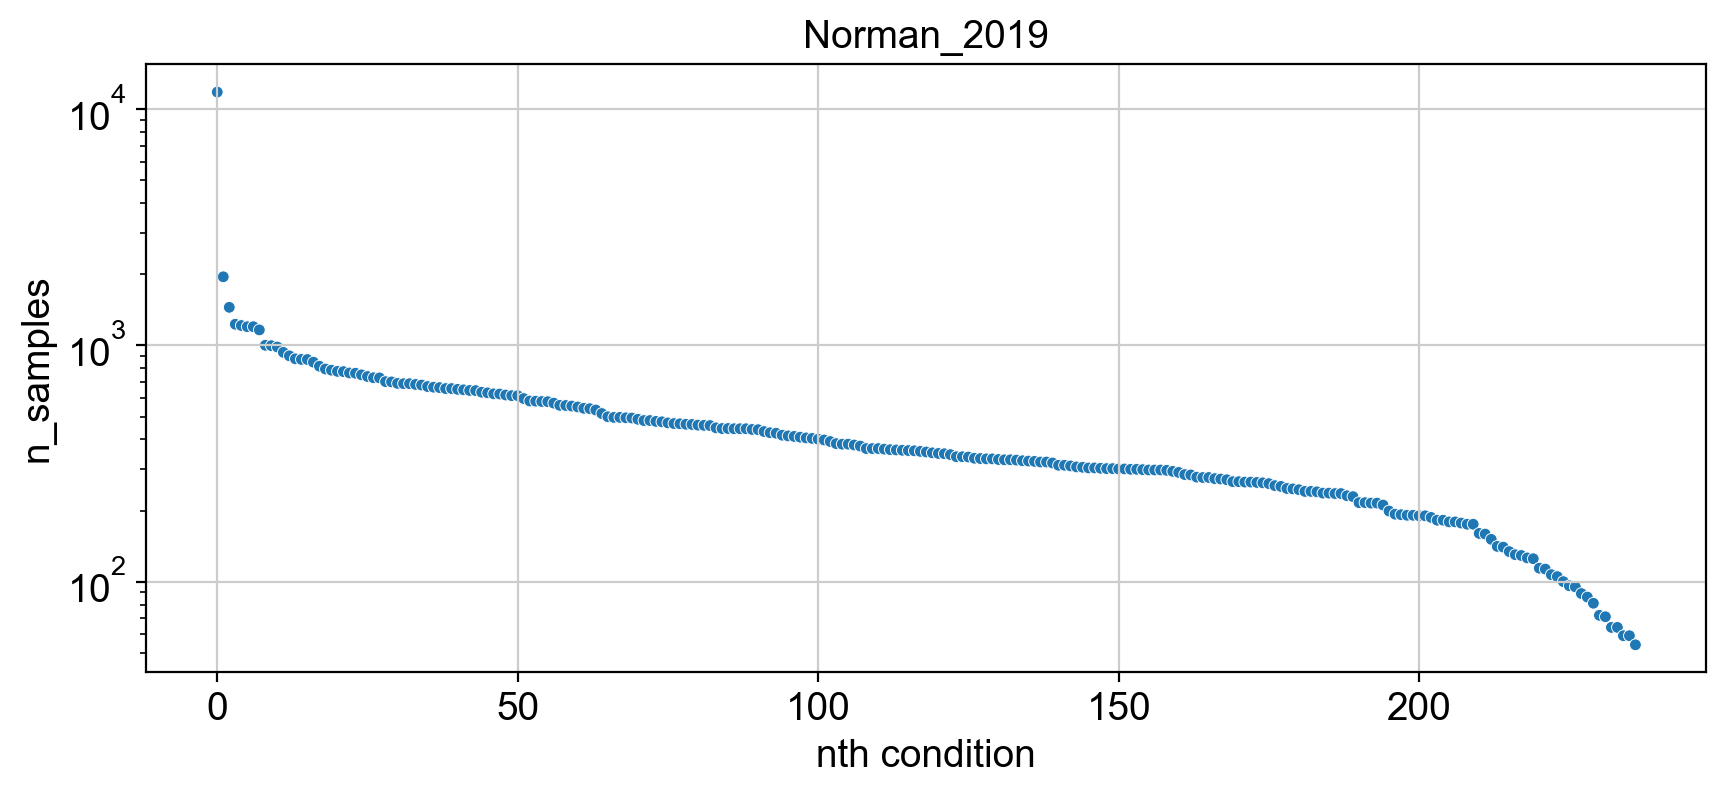

,nth condition,condition,n_samples
0,0,JAK,1503
1,1,TIMP,1483
2,2,IFNGR,1427
3,3,SLC5A,1212
4,4,NPC,1151


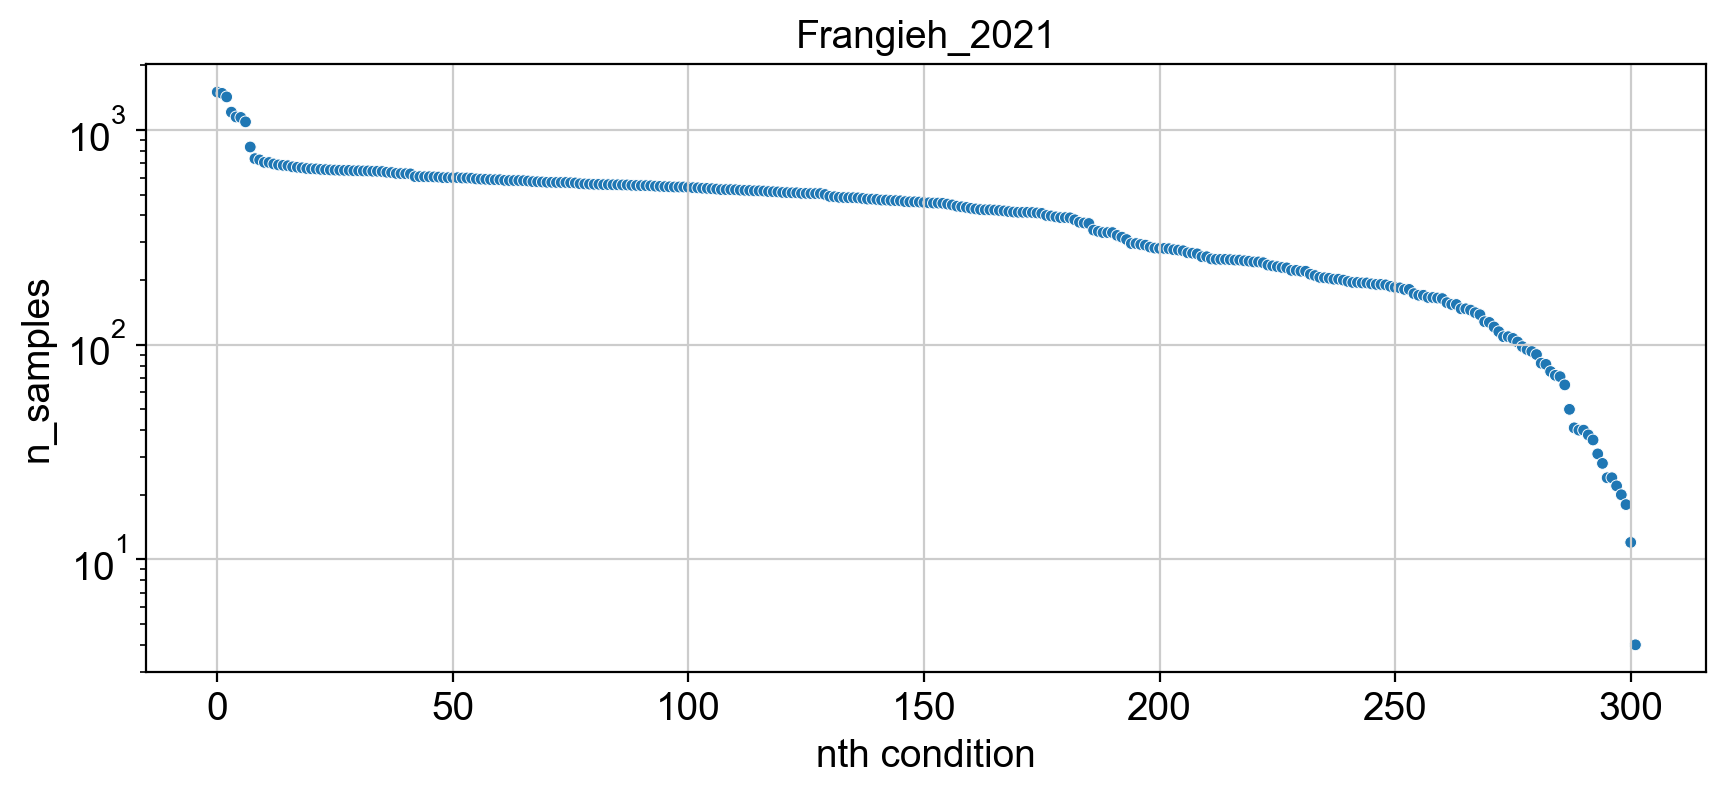

,nth condition,condition,n_samples
0,0,Vehicle,12966
1,1,PD98059,3754
2,2,Tranylcypromine,3735
3,3,WP1066,3711
4,4,RG108,3710


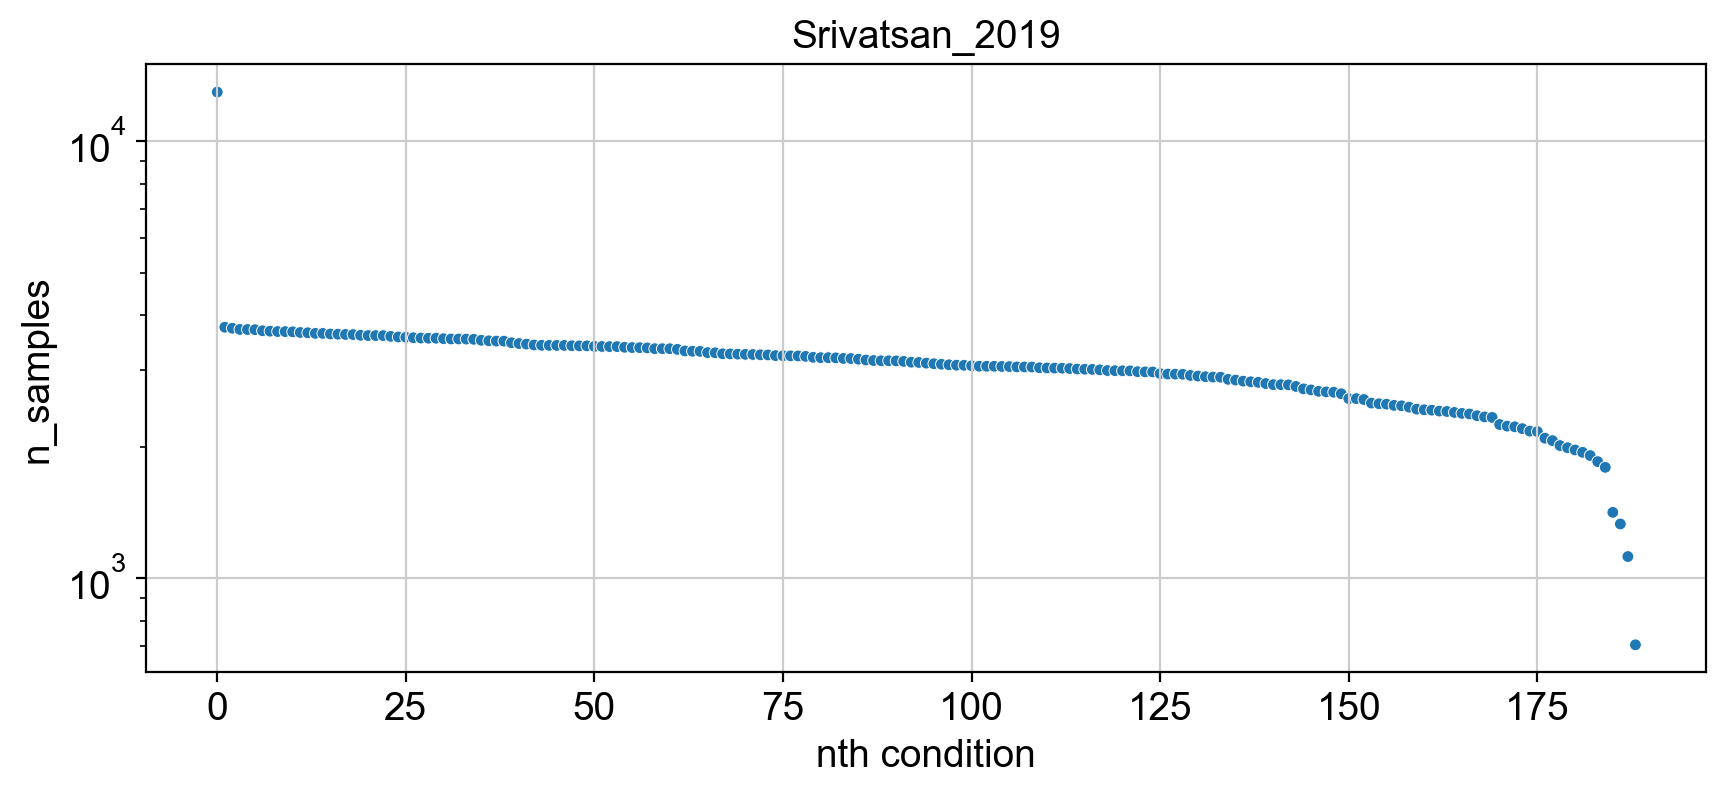

In [38]:
for a in adatas:
    df = pd.DataFrame(a.obs.perturbation_name.value_counts())
    df = df.reset_index().reset_index()
    df.columns = ['nth condition', 'condition', 'n_samples']
    display(df.head(5))

    plt.figure(figsize=(10, 4))
    sns.scatterplot(data=df, x='nth condition', y='n_samples', size=1, legend=None)
    plt.yscale('log')
    plt.title(a.obs.dataset.values[0])
    plt.show()

Which perturbations exist across multiple datasets?

In [39]:
df = pd.crosstab(adata.obs.perturbation_name, adata.obs.dataset)
df = df[np.count_nonzero(df, axis=1) > 1]
df

dataset,Dixit_2016,Frangieh_2021,Norman_2019,Srivatsan_2019
perturbation_name,,,,
EGR1,6181,0,321,0
IRF1,3837,0,427,0
NCL,0,121,237,0
SET,0,415,985,0


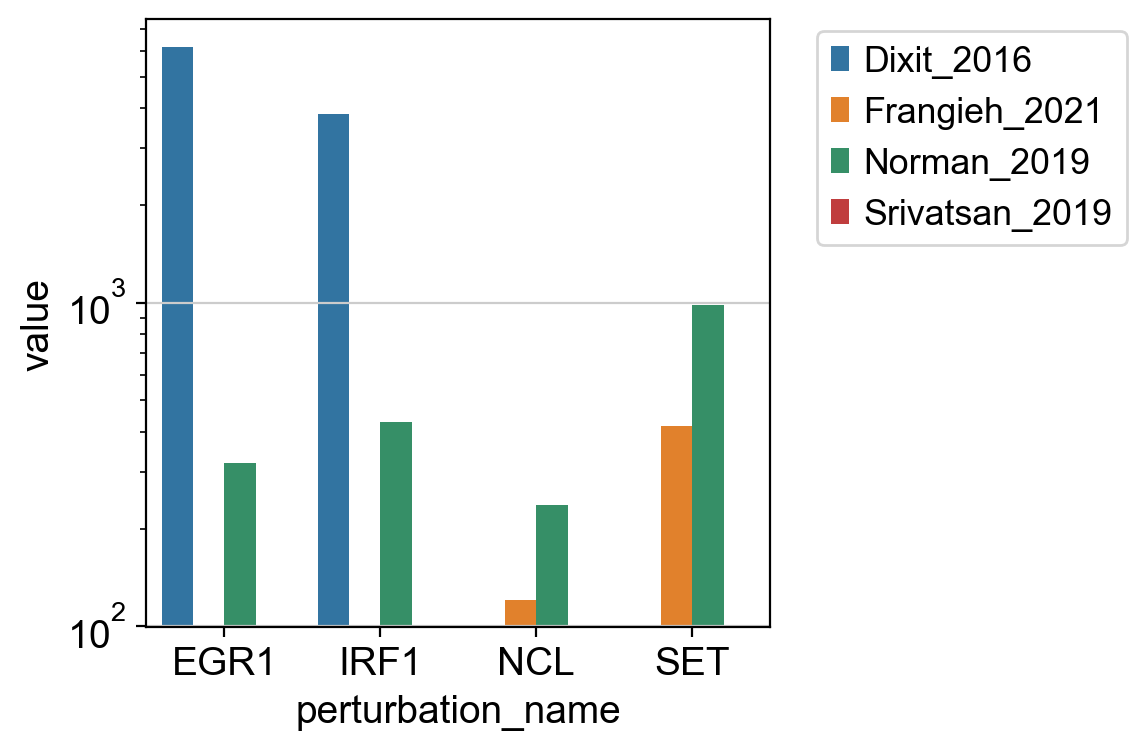

In [59]:
sns.barplot(data = df.reset_index().melt(id_vars='perturbation_name'), x='perturbation_name', y='value', hue='dataset')
plt.yscale('log')
plt.legend(bbox_to_anchor = (1.6, 1.01));

## Train a model

Let's train the simplest model we can - a sgRNA classifier. From the weights of the model, you could extract common features of the sgRNA's effect.

In [5]:
subset = adata[adata.obs.perturbation_name.isin(df.index)]
subset

View of AnnData object with n_obs × n_vars = 12524 × 12738
    obs: 'n_genes', 'leiden', 'perturbation_name', 'perturbation_type', 'perturbation_value', 'perturbation_unit', 'dataset'
    obsm: 'X_pca', 'X_umap'

Generate a random train-test split.

In [6]:
from sklearn.model_selection import train_test_split
test_idx, train_idx = train_test_split(subset.obs.index, test_size=.2)

test = subset[test_idx]
train = subset[train_idx]

Train a model.

In [7]:
clf = sk.linear_model.LogisticRegression()
clf.fit(train.X, train.obs.perturbation_name.values)

LogisticRegression()

Evaluate on training data.

In [8]:
clf.score(train.X, train.obs.perturbation_name.values)

1.0

Evaluate on test data.

In [9]:
clf.score(test.X, test.obs.perturbation_name.values)

0.5824932628006787

In [10]:
print(sk.metrics.classification_report(
    test.obs.perturbation_name.values,
    clf.predict(test.X)
))

              precision    recall  f1-score   support

        EGR1       0.62      0.66      0.64      5246
        IRF1       0.43      0.38      0.40      3368
         NCL       0.47      0.22      0.30       290
         SET       0.79      0.91      0.84      1115

    accuracy                           0.58     10019
   macro avg       0.58      0.54      0.55     10019
weighted avg       0.57      0.58      0.57     10019



Not bad for a 4-class classification problem.

Much harder case: let's try leaving out one Norman et al. 2019 and only learn the treatments from the other two datasets. We've performed no batch correction between datasets so we would expect this to be extremely difficult for a linear model.

In [11]:
test = subset[subset.obs.dataset == 'Norman_2019']
train = subset[subset.obs.dataset != 'Norman_2019']

In [12]:
clf = sk.linear_model.LogisticRegression()
clf.fit(train.X, train.obs.perturbation_name.values)

LogisticRegression()

In [13]:
print(sk.metrics.classification_report(
    test.obs.perturbation_name.values,
    clf.predict(test.X)
))

              precision    recall  f1-score   support

        EGR1       0.14      0.46      0.22       321
        IRF1       0.17      0.37      0.23       427
         NCL       0.00      0.00      0.00       237
         SET       0.00      0.00      0.00       985

    accuracy                           0.16      1970
   macro avg       0.08      0.21      0.11      1970
weighted avg       0.06      0.16      0.09      1970



Indeed, we see that the linear model is not at all predictive due to the batch effect across datasets.